In [5]:
%matplotlib widget
import numpy as np
import json, os, glob
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *
from alvra_tools.XAS_utils import *

import warnings
warnings.filterwarnings('ignore')

# Reduce data 

In [16]:
pgroup = 'p21960'

#runlist = [45]
runlist = [93]

##############################################
from textwrap import wrap
from sfdata import SFScanInfo
jsonlist = []
for run in runlist:
    jsonfile = ''
    #jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, run))[0]
    jsonfile = glob.glob('/sf/alvra/data/{}/work/testdata/*{:04d}*/meta/scan.json'.format(pgroup, run))[0]
    jsonlist.append(jsonfile)
print ("will reduce {} run(s): {}".format(len(jsonlist), runlist))
titlestring = pgroup + ' --- ' +str(runlist)
jsonlist

will reduce 1 run(s): [45]


['/sf/alvra/data/p21960/work/testdata/run0045-FePhen_Timescan_7119p5eV_001/meta/scan.json']

In [21]:
from sfdata import SFScanInfo
scan = SFScanInfo(jsonlist[0])
scan.files[0]

['/sf/alvra/data/p21960/work/testdata/run0045-FePhen_Timescan_7119p5eV_001/data/acq0001.PVDATA.h5',
 '/sf/alvra/data/p21960/work/testdata/run0045-FePhen_Timescan_7119p5eV_001/data/acq0001.BSDATA.h5']

In [17]:
channel_diode_1 = 'SARES12-GES1:PR1_CH1_VAL_GET'
channel_diode_2 = 'SARES12-GES1:PR1_CH2_VAL_GET'

In [22]:
channel_delay_motor = channel_delay_beckhoff
detector_XAS_1 = channel_diode_1
detector_XAS_2 = channel_diode_2
detector_Izero = channel_Izero122

reducedir='/sf/alvra/data/{}/work/Reduced_data/'.format(pgroup)
saveflag = True

TT = TT_PSEN126

pump_1, unpump_1, pump_2, unpump_2, Izero_pump, Izero_unpump, Delays_stage, arrTimes, Delays_corr, energy, readbacks, corr1, corr2 = \
XAS_scanPP(reducedir, saveflag, jsonlist, TT, channel_delay_motor, detector_XAS_1, detector_XAS_2, detector_Izero)

/sf/alvra/data/p21960/work/testdata/run0045-FePhen_Timescan_7119p5eV_001/meta/scan.json
Step 111 of 111: Processing acq0111

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet           1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-CVME-EVR0:DUMMY_PV3_NBS    992 / 1003 -> 1% loss ▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude 1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position  1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES12-GES1:PR1_CH1_VAL_GET      1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES12-GES1:PR1_CH2_VAL_GET      1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY         1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAT-L-BECKBS:PR1_CH1_VAL_GET    1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 990 / 1003 -> 1% loss
complete channels: 0 / 8 -> 100% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump s

In [ ]:
Plot_correlations(pgroup, reducedir, runlist, timescan=True)#, lowlim = 0.93)
Plot_rawdata_2diodes(pgroup, reducedir, runlist, timescan=True)

<a id='old'></a>
## Old

In [6]:
pgroup='p21992'
runnumber = 90

print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str(pgroup + ' --- ' +jsonfile.split('/')[-3])
run_name = jsonfile.split('/')[-3]
jsonfile

run: 0090


'/sf/alvra/data/p21992/raw/run0090-MbCO_XANES_preedge_500fs/meta/scan.json'

In [7]:
Two_diodes = True

reducedir='/sf/alvra/data/{}/work/Reduced_data/old_way/'.format(pgroup)
saveflag=True

quantile_corr = 0.7

channel_delay_motor = channel_delay_topas
detector_XAS_1 = channel_diode_1
detector_XAS_2 = channel_diode_2
detector_Izero = channel_Izero122

#######################################################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

LoadXANES(Two_diodes, scan, detector_XAS_1, detector_XAS_2, detector_Izero, quantile_corr, saveflag, reducedir, run_name)
data, _ = load_reduced_data(pgroup, reducedir, [runnumber])
globals().update(data)

Processing: run0090-MbCO_XANES_preedge_500fs
Step 13 of 13: Processing acq0013

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet      1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES12-GES1:PR1_CH1_VAL_GET 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES12-GES1:PR1_CH2_VAL_GET 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY    1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1001 / 1001 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 495 pump and 495 unpump shots
245 shots out of 495 survived
237 shots out of 495 survived
Step 13 of 13: Processed acq0013
correlation Diode1 (all shots) = 0.995761781296927
correlation Diode2 (all shots) = 0.9921604415779349
------------------------------
Processed 13 out of 13 files


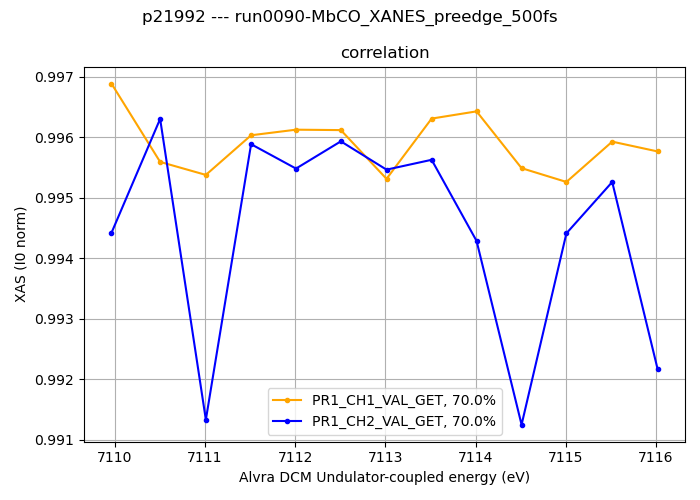

In [8]:
if not Two_diodes:
    detector_XAS_2 = detector_XAS_1
Plot_correlation(titlestring, scan, data, quantile_corr, detector_XAS_1, detector_XAS_2, timescan=False)

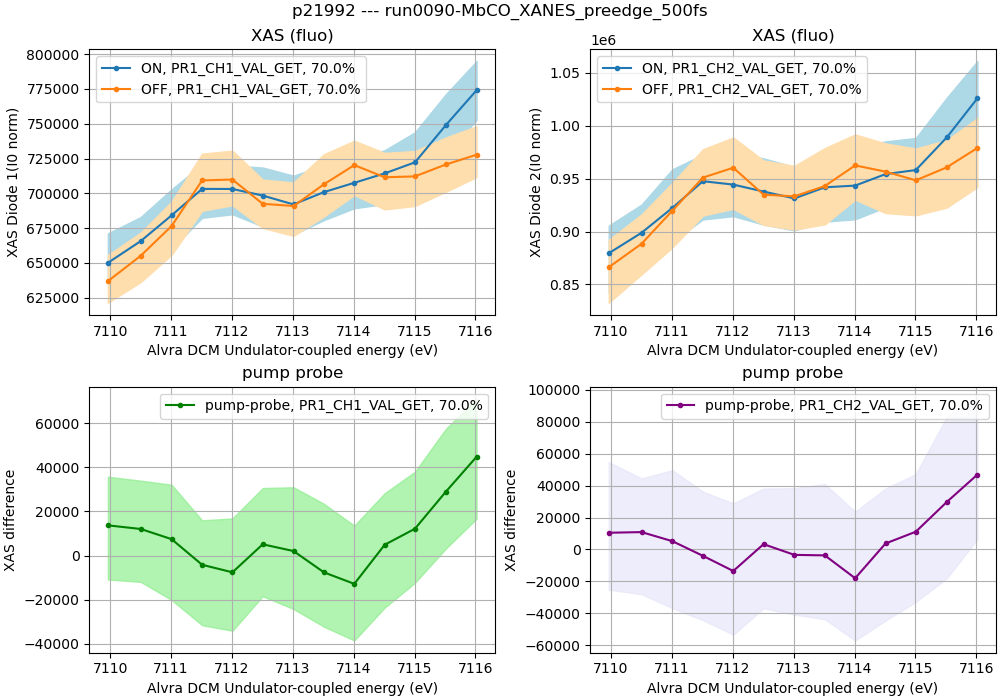

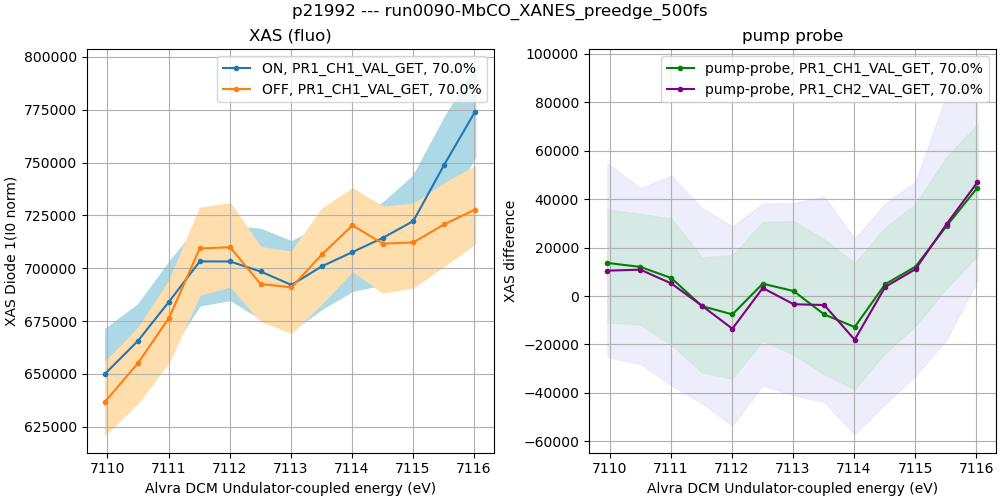

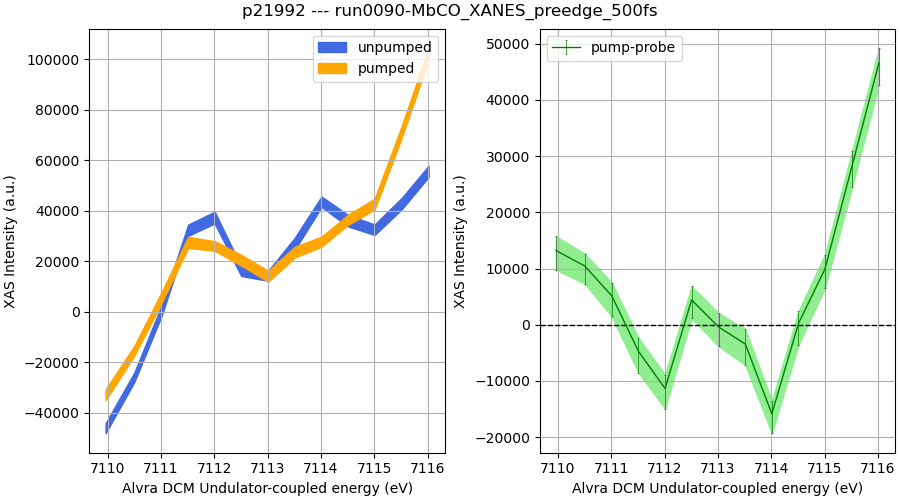

In [9]:
if Two_diodes:
    XAS1_pump_probe, XAS2_pump_probe, Energy_eV = Plot_2diodes_4figs(titlestring, scan, data, 
                                                              quantile_corr, detector_XAS_1, detector_XAS_2, timescan=False)
    XAS1_pump_probe, XAS2_pump_probe, Energy_eV = Plot_2diodes_2figs(titlestring, scan, data, 
                                                              quantile_corr, detector_XAS_1, detector_XAS_2, timescan=False)
    
    Energy_eV, ave_pp1 = Plot_2diodes_Averaged_2figs(titlestring, scan, data, timescan=False)
else:
    XAS1_pump_probe, Energy_eV = Plot_1diode(titlestring, scan, data, 
                                            quantile_corr, detector_XAS_1, timescan=False)